In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns

In [2]:
import numpy as np

In [3]:
df_posts = pd.read_csv('/home/sam/data/stormfront/posts.csv', dtype={
    'author': np.dtype(np.object),
    'author_join_date': np.dtype(np.object),
    'author_location': np.dtype(np.object),
    'author_posts': np.dtype(np.float64),
    'author_title': np.dtype(np.object),
    'content': np.dtype(np.object),
    'post_in_thread': np.dtype(np.int64),
    'thread_url': np.dtype(np.object),
    'post_date': np.dtype(np.object),
    'post_id': np.dtype(np.int64)
}, parse_dates=['author_join_date', 'post_date'])

In [678]:
df_posts.count()

author              972846
author_join_date    961380
author_location     612940
author_posts        961380
author_title        972846
content             972846
post_in_thread      972846
thread_url          972846
post_date           972846
dtype: int64

In [5]:
df_authors = pd.read_csv('~/far-right/stormfront/authors.csv', parse_dates=['author_join_date'])

In [6]:
df_titles = pd.read_csv('/home/sam/far-right/stormfront/thread-titles.csv')

# Create plain-text out of forum posts

Forum posts are currently in raw HTML. We need to get them into a state where they can be tokenized cleanly, without losing information we want. This involves:

* Parsing out links (Stormfront covers all external links with a "redirect" URL)
* Replacing linebreaks with newlines
* Removing images, and replacing them with their title text. Emojis are replaced with their filename.
* Parsing out the tree structure of posts that quote each other. We will generate a table of "subposts", each of which consists of `content` and a `parent`. The `parent` is the quoted text, and the `content` is the response (all text before the next quote)

In [79]:
from lxml import etree
from io import StringIO
import urllib

parser = etree.HTMLParser()

def parse_stormfront_redirect_link(link):  
    pre, _, redirect = link.partition('https://www.stormfront.org/forum/redirect-to/?redirect=')
    if pre:
        return link
    
    return urllib.parse.unquote(redirect)

parse_stormfront_redirect_link('https://www.stormfront.org/forum/redirect-to/?redirect=http%3A%2F%2Fwww.reuters.com%2Farticle%2FoddlyEnoughNews%2FidUSN2430572020070524%3FfeedType%3DRSS%26rpc%3D22%26pageNumber%3D2')

'http://www.reuters.com/article/oddlyEnoughNews/idUSN2430572020070524?feedType=RSS&rpc=22&pageNumber=2'

In [682]:
def extract_links(content):
    root = etree.parse(StringIO(content), parser)
    link_elems = root.findall('.//a[@href]')
    return [parse_stormfront_redirect_link(elem.attrib['href']) for elem in link_elems]

In [92]:
for i, row in df_posts.iterrows():
    if i % 500 == 0:
        print('.', end='')
    links = extract_links(row.content)
    df_posts.set_value(i, 'links', links)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [14]:
from bs4 import BeautifulSoup
def replace_links_with_their_text(soup):
    links = soup.find_all('a')
    for link in links:
        link.replace_with(link.get_text())
        
    return soup

replace_links_with_their_text(BeautifulSoup('<div><a href="blah">link text</a> hello</div>', 'html.parser'))

<div>link text hello</div>

In [15]:
def extract_post_id(content):
    soup = BeautifulSoup(content, 'html.parser')
    post_message_id = (soup.div)['id']
    _, _, post_id = post_message_id.partition('post_message_')
    return post_id

extract_post_id(df_posts.head().content[1])

'4230591'

In [16]:
for i, row in df_posts.iterrows():
    if i % 1000 == 0:
        print('.', end='')
    
    post_id = extract_post_id(row.content)
    df_posts.set_value(i, 'post_id', post_id)

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [17]:
# Some posts were duplicated, perhaps because a new post bumped the post to a new page before
# that new page was scraped
df_posts.drop_duplicates(subset='post_id', inplace=True)

In [ ]:
df_posts.to_csv('~/data/stormfront/posts.csv', index=False)

In [686]:
def replace_images(soup):
    images = soup.find_all('img')
    for image in images:
        
        # This is in quotes, and kind of useless
        if image['src'] == 'https://www.stormfront.org/forum/images/buttons/viewpost.gif':
            image.extract()
            continue
        
        if image['src'].startswith('https://www.stormfront.org/forum/images/smilies/'):
            _, _, emoji_file = image['src'].partition('https://www.stormfront.org/forum/images/smilies/')
            emoji = ' {} '.format(emoji_file)
            image.replace_with(emoji)
            continue
        
        src = image.get('src', '')
        title = image.get('title', '')
        image_replacement = '%s {%s}' % (src, title)
        image.replace_with(image_replacement)
    
    return soup

print(replace_images(BeautifulSoup(df_posts.ix[0].content, 'html.parser')))
print(replace_images(BeautifulSoup('Some text <img src="image.jpg" title="Title" />', 'html.parser')))
print(replace_images(BeautifulSoup('Some text <img src="thumbnail.jpg" />', 'html.parser')))

<div id="post_message_4230580">
<a href="https://www.stormfront.org/forum/redirect-to/?redirect=http%3A%2F%2Fwww.reuters.com%2Farticle%2FoddlyEnoughNews%2FidUSN2430572020070524%3FfeedType%3DRSS%26rpc%3D22%26pageNumber%3D2" onclick="ga('send', 'event', 'Outgoing', 'www.reuters.com', '/article/oddlyEnoughNews/idUSN2430572020070524?feedType=RSS&amp;rpc=22&amp;pageNumber=2');" rel="nofollow" target="_blank">http://www.reuters.com/article/oddly...2&amp;pageNumber=2</a><br/>
<br/>
Florida tries to wipe out cat-sized African rats<br/>
<br/>
[Another unwanted African import...]<br/>
[They say Owners Resemble Their Pets--check out the photo!]      smile.gif  <br/>
<br/>
The (Gambian pouch)African rats can weigh 6 to 9 pounds (2.7-4 kg), with body shades ranging from brown to gray. They have large ears, black, beady eyes, hamster-like pouched facial cheeks, sharp teeth and distinctive long, stringy and white-marked tails.<br/>
<br/>
"They're a big rodent. They're not particularly attractive. I d

In [687]:
def clean_soup(soup):
    soup.div.unwrap() # Remove outermost div
    [br.extract() for br in soup.find_all('br')] # Remove all breaks

def remove_markup(soup):    
    replace_images(soup)
    replace_links_with_their_text(soup)
    return str(soup)

soup = BeautifulSoup(df_posts.content[1], 'html.parser')
clean_soup(soup)
remove_markup(soup)
print(soup)


<div style="margin:20px; margin-top:5px; ">
<div class="smallfont" style="margin-bottom:2px">Quote:</div>
<table border="0" cellpadding="6" cellspacing="0" width="100%">
<tr>
<td class="alt2" style="border:1px inset">
<div>
					Originally Posted by <strong>salvete amici</strong>

</div>
<div style="font-style:italic">http://www.reuters.com/article/oddly...2&amp;pageNumber=2

Florida tries to wipe out cat-sized African rats

[Another unwanted African import...]
[They say Owners Resemble Their Pets--check out the photo!]      smile.gif  

The (Gambian pouch)African rats can weigh 6 to 9 pounds (2.7-4 kg), with body shades ranging from brown to gray. They have large ears, black, beady eyes, hamster-like pouched facial cheeks, sharp teeth and distinctive long, stringy and white-marked tails.

"They're a big rodent. They're not particularly attractive. I don't understand why anyone would want them as a pet," Witmer said. "They're very messy animals."</div>
</td>
</tr>
</table>
</div>I sup

In [307]:
def content_until_next_quote(quote, continuation=''):
    while True:
        if not quote:
            return continuation

        element = quote.next_sibling
        if not element:
            return continuation

        if element.name == 'div' and element.attrs == {'style': 'margin:20px; margin-top:5px; '}:
            return continuation
        
        quote = element
        continuation = continuation + ' ' + str(element)

In [309]:
import re
numbers_at_the_end = re.compile('\d+$')

def extract_subposts(soup):
    subposts = []
    quotes = soup.find_all('div', style='margin:20px; margin-top:5px; ')
    
    if not quotes:
        return [(None, None, str(soup))]
    
    for quote in quotes:
        response = content_until_next_quote(quote)
        quote = quote.extract()
        
        parent_link = quote.find('a', href=lambda link: link.startswith('https://www.stormfront.org/forum/showthread.php?p='))
        try:
            parent_id = numbers_at_the_end.search(parent_link['href']).group()
            parent_content = None
        except TypeError:
            parent_id = None
            parent_content = quote.get_text()
        subposts.append((parent_id, parent_content, response))
        
    return subposts

soup = BeautifulSoup(df_posts.ix[1].content, 'html.parser')
clean_soup(soup)
print(extract_subposts(soup))

[('4230580', None, ' I suppose they wouldn\'t go down well with a dose of rabies and other known diseases that rats carry. <img alt="" border="0" class="inlineimg" src="https://www.stormfront.org/forum/images/smilies/crazy.gif" title="crazy"/> \n \n')]


In [310]:
subpost_table = []

for i, row in df_posts.iterrows():
    if i % 1000 == 0:
        print('.', end='')
        
    soup = BeautifulSoup(row.content, 'html.parser')
    clean_soup(soup)
    
    subposts = extract_subposts(soup)
        
    for parent_id, parent_content, content in subposts:
        subpost_soup = BeautifulSoup(content, 'html.parser')
        remove_markup(subpost_soup)

        subpost_row = (row.post_id, parent_id, parent_content, str(subpost_soup))

        subpost_table.append(subpost_row)

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [314]:
df_subposts = pd.DataFrame(subpost_table, columns=['post_id', 'parent_id', 'parent_content', 'content'])

print(df_subposts.shape)

df_subposts.head()

(1026449, 4)


,post_id,parent_id,parent_content,content
0,4230580,None,None,\nhttp://www.reuters.com/article/oddly...2&amp...
1,4230591,4230580,None,I suppose they wouldn't go down well with a d...
2,4230635,4230580,None,The blacks or the rats? confused.gif \n
3,4230666,4230580,None,OMG I'll have nightmares for weeks now...YUCK...
4,4230668,None,None,\r\n\t\t\t\r\n\t\t\tAre you talking about actu...


In [317]:
df_subposts.parent_content.count()

108060

# There are still tags in the data!

* Extract youtube links from embeds
* Remove all other tags

In [378]:
df_subposts['video_links'] = [[] for _ in range(df_subposts.shape[0])]

In [379]:
for i, row in df_subposts.iterrows():
    if i % 1000 == 0:
        print('.', end='')
    soup = BeautifulSoup(row.content, 'html.parser')
    iframes = soup.find_all('iframe')
    video_links = [iframe['src'] for iframe in iframes]
    
    df_subposts.set_value(i, 'video_links', video_links)
    df_subposts.set_value(i, 'content', soup.get_text())

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

# Timeline analysis

The Southern Poverty Law Center writes about Stormfront:

> [A] series of reverses — the 2008 assertion by Black’s wife that she was not a racist, a similar declaration by his son in 2010, and the Southern Poverty Law Center’s exposure of the identity of many Stormfront funders and the fact its registered users have been behind almost 100 murders — have caused a series of problems for the Web forum. Today, Black struggles with a continuing decline in site visitors, chronic financial problems and his own health issues.

Let's see if that holds up in our data.


In [7]:
df_subposts = pd.read_csv('~/data/stormfront/subposts.csv')

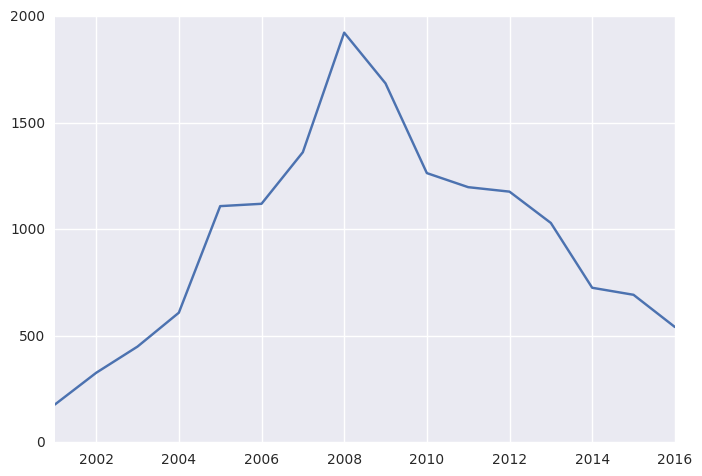

In [8]:
import seaborn as sns

users_join_by_year = df_authors.groupby(by=pd.DatetimeIndex(df_authors.author_join_date).year).author.count()

users_join_by_year.drop(1994).plot()

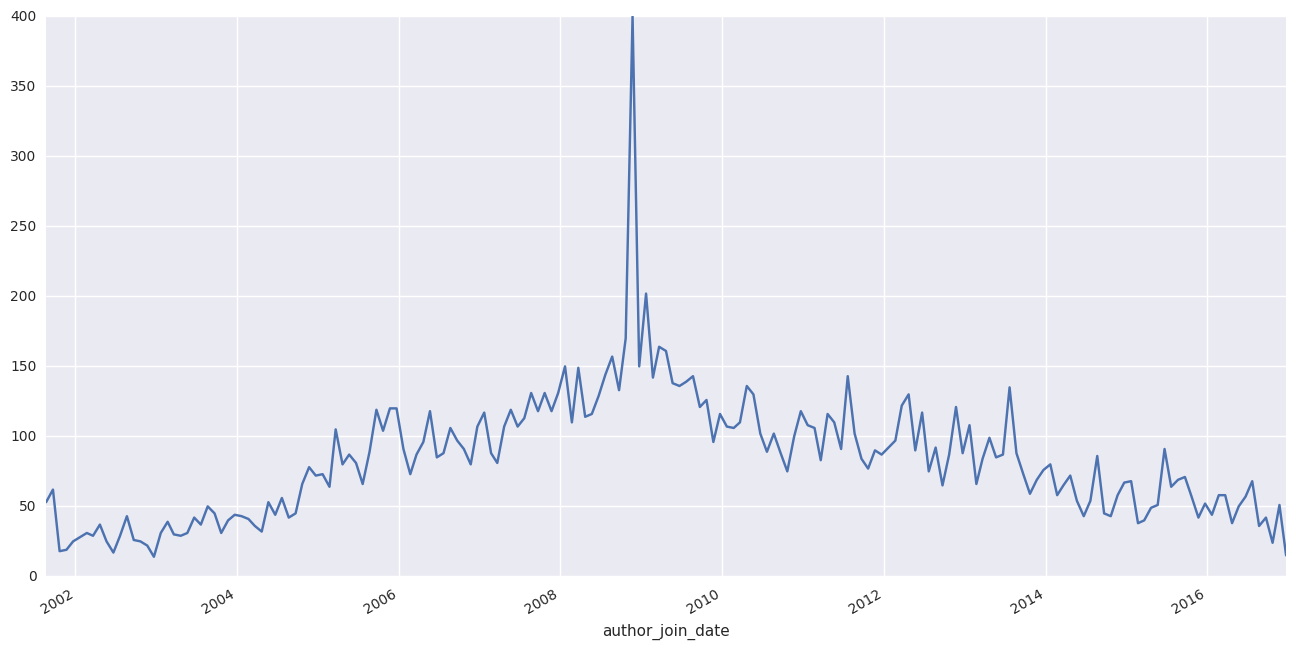

In [544]:
fig = plt.figure(figsize=(16, 8))

df_authors.groupby(df_authors.author_join_date).author.count().ix[1:].plot() # Drop 1994

Within the posters of the News and Articles subforum, newly registered users are declining. It looks like posts spiked around Barack Obama's election.

But are overall posts on the decline as well?

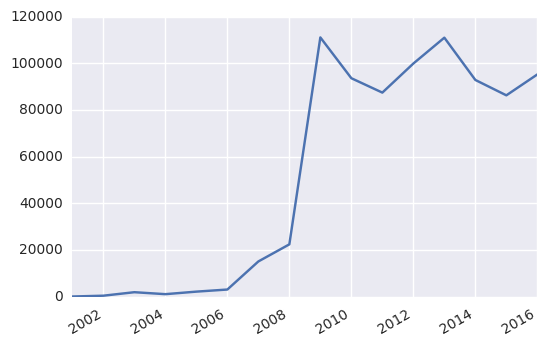

In [541]:
post_dates = pd.DatetimeIndex(df_posts.post_date)

import matplotlib.pyplot as plt

fig = plt.figure()

df_posts.groupby([post_dates.year]).count().author.plot()

fig.autofmt_xdate()

Interestingly, no. The total number of posts has stayed at a heightened level, and peaks around the presidential election cycle.

In [597]:
import matplotlib.dates as mdates

In [621]:
counts_by_date_multi = df_posts.groupby([post_dates.year, post_dates.month]).count().author

In [630]:
counts_by_date_multi.index = [date(int(year), int(month), 1) for year, month in zip(counts_by_date_multi.index.get_level_values(0), counts_by_date_multi.index.get_level_values(1))]

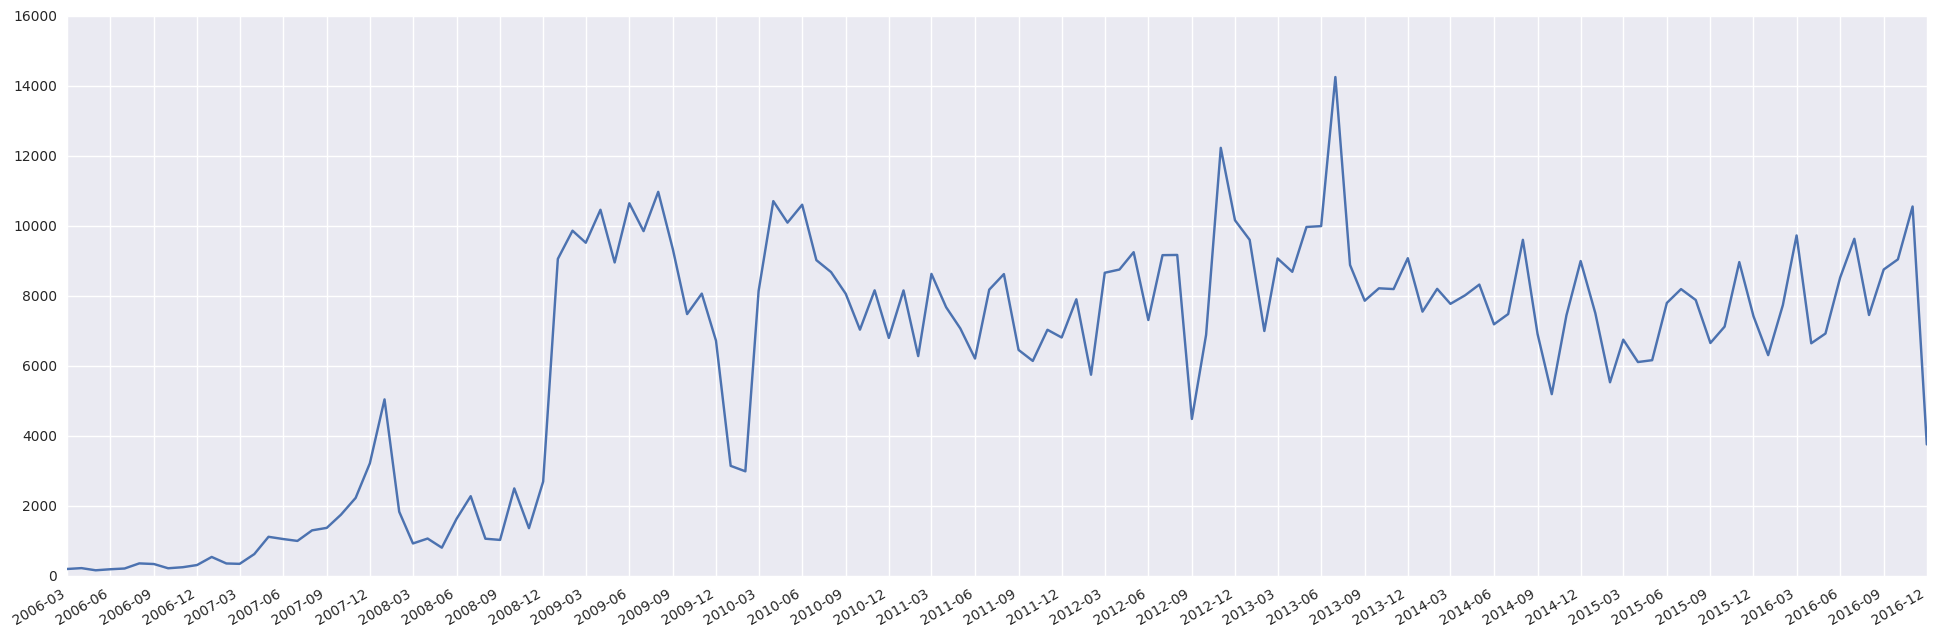

In [639]:
fig = plt.figure(figsize=(24, 8))

ax = counts_by_date_multi[50:].plot()

month_locator = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(month_locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

plt.show()

Let's look at active users per 3-month period. An active user will be a user who posted anything in the last 3 months.

In [663]:
from dateutil import parser

parser.parse('2016')

datetime.datetime(2016, 1, 4, 0, 0)

In [689]:
df_posts_times_sorted = df_posts.sort_values(['author', 'post_date'])

In [690]:
dates_since_last_post = df_posts_times_sorted.groupby('author', sort=False).post_date.diff()

In [691]:
df_posts_times_sorted['post_date_difference'] = dates_since_last_post

In [704]:
df_posts['post_month'] = df_posts.post_date.dt.to_period('M')

In [797]:
authors_posting_per_month = df_posts.groupby('post_month').author.nunique()
authors_posting_per_month

post_month
2001-09     13
2001-10      8
2001-11      8
2001-12      5
2002-03     13
2002-04      1
2002-05      9
2002-06     16
2002-07     10
2002-08      9
2002-09     14
2002-10     22
2002-11     32
2002-12     21
2003-01     37
2003-02     45
2003-03     35
2003-04     32
2003-05     29
2003-06     53
2003-07     27
2003-08     51
2003-09     65
2003-10     54
2003-11     33
2003-12     49
2004-01     35
2004-02     86
2004-03     54
2004-04     49
          ... 
2014-07    783
2014-08    881
2014-09    778
2014-10    695
2014-11    808
2014-12    817
2015-01    790
2015-02    673
2015-03    709
2015-04    706
2015-05    676
2015-06    836
2015-07    791
2015-08    720
2015-09    699
2015-10    699
2015-11    755
2015-12    730
2016-01    685
2016-02    727
2016-03    740
2016-04    675
2016-05    673
2016-06    759
2016-07    791
2016-08    675
2016-09    667
2016-10    680
2016-11    792
2016-12    505
Freq: M, Name: author, dtype: int64

In [711]:
df_authors['author_join_month'] = df_authors.author_join_date.dt.to_period('M')

df_authors.head()

,author,author_join_date,author_location,author_posts,author_title,primary_state,mentions_negro,author_join_month
0,**JT**,2001-09-22,Western Washington,726.0,Forum Member,washington,False,2001-09
1,*Hither_Shore*,2004-09-22,NaN,452.0,Forum Member,NaN,False,2004-09
2,*turtle_88*,2008-01-22,NaN,74.0,Account Inactive,NaN,False,2008-01
3,+213Theodoric+,2004-04-22,"Thunderbolt, Colonial Georgia, Norð Amerika",49.0,Forum Member,georgia,False,2004-04
4,+dezelman+,2006-06-22,NaN,52.0,Forum Member,NaN,False,2006-06


In [747]:
registered_users_by_month = df_authors.groupby('author_join_month').author.count()
cumulative_users_by_month = registered_users_by_month.cumsum()

In [ ]:
registered_users_by_month.index = registered_users_by_month.index.to_timestamp()
cumulative_users_by_month.index = cumulative_users_by_month.index.to_timestamp()

In [800]:
authors_posting_per_month.index = authors_posting_per_month.index.to_datetime()

/home/sam/text-analytics/venv/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: to_datetime is deprecated. Use self.to_timestamp(...)
  if __name__ == '__main__':


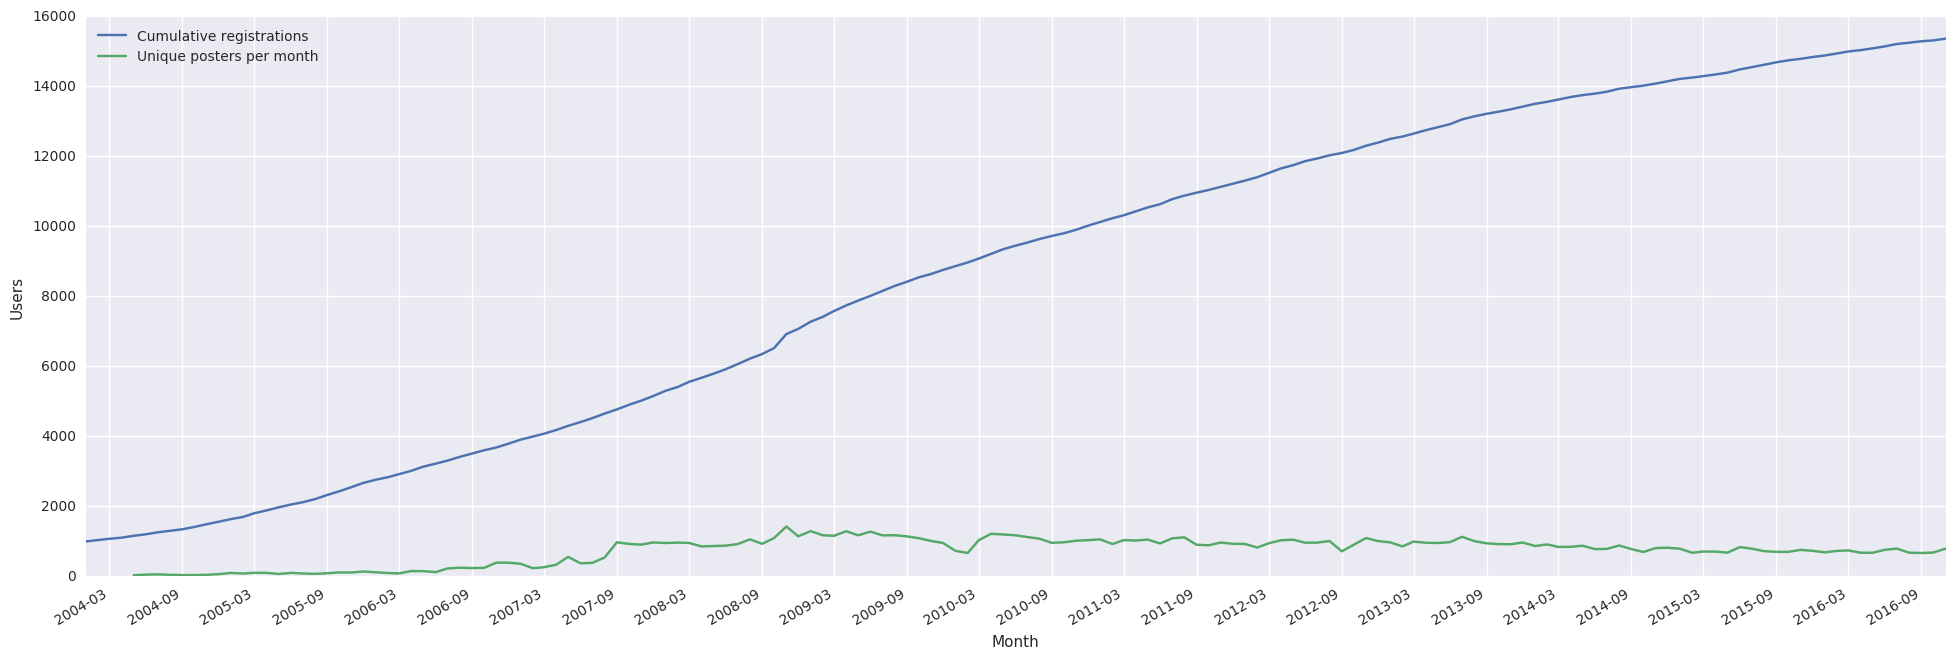

In [801]:
fig = plt.figure(figsize=(24, 8))

plt.plot(cumulative_users_by_month[30:-1], label="Cumulative registrations")
plt.plot(authors_posting_per_month[30:-1], label="Unique posters per month")

month_locator = mdates.MonthLocator(interval=6)
fig.axes[0].xaxis.set_major_locator(month_locator)
fig.axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.axes[0].xaxis.set_label_text('Month')
fig.axes[0].yaxis.set_label_text('Users')
fig.autofmt_xdate()

plt.legend(loc='best')

In [753]:
first_post = df_posts.sort('post_date').groupby('author', sort=False).post_date.first()

first_post

/home/sam/text-analytics/venv/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


author
USSKIN             2001-09-12 21:40:00
Strasser           2001-09-19 15:12:00
dna88              2001-09-20 02:52:00
Kirbysmith         2001-09-23 00:16:00
Jack Boot          2001-09-23 07:13:00
Tacitus76          2001-09-23 18:31:00
eerie              2001-09-23 19:25:00
lombard10          2001-09-23 22:15:00
Neon Genesis       2001-09-23 22:27:00
beachunit2         2001-09-26 19:36:00
Hatch              2001-09-26 20:37:00
whitefight88       2001-09-27 12:36:00
novusthule         2001-09-27 13:47:00
William Z          2001-10-03 19:14:00
Braveheart         2001-10-03 23:21:00
blondebrains       2001-10-04 19:27:00
templar cross      2001-10-04 20:17:00
guest001           2001-10-07 22:07:00
Adolar             2001-10-07 23:15:00
Guest              2001-10-10 04:28:00
SDY6401            2001-10-10 10:12:00
DUTCHY             2001-11-01 16:22:00
barosa88           2001-11-01 18:29:00
Robert E. Lee      2001-11-01 22:23:00
Craig McDermott    2001-11-01 23:01:00
Gandalf           

In [761]:
first_post_df = first_post.reset_index()

first_post_df['post_month'] = pd.DatetimeIndex(first_post_df.post_date).to_period('M')

In [768]:
first_post_month = first_post_df.groupby('post_month').author.count()
first_post_month.index = first_post_month.index.to_timestamp()

In [813]:
def plot_two(data1, data2, xlabel, ylabel1, ylabel2, title=''):
    fig, ax1 = plt.subplots(figsize=(24, 8))

    color1 = '#3498db'
    color2 = '#e74c3c'
    
    ax1.set_title(title)
    ax1.xaxis.set_major_locator(month_locator)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.plot(data1, color=color1, alpha=0.7)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1, color=color1)
    for tleft in ax1.get_yticklabels():
        tleft.set_color(color1)

    ax2 = ax1.twinx()
    ax2.plot(data2, color=color2, alpha=0.7)
    ax2.set_ylabel(ylabel2, color=color2)
    for tright in ax2.get_yticklabels():
        tright.set_color(color2)
    
    fig.autofmt_xdate()
    plt.show()

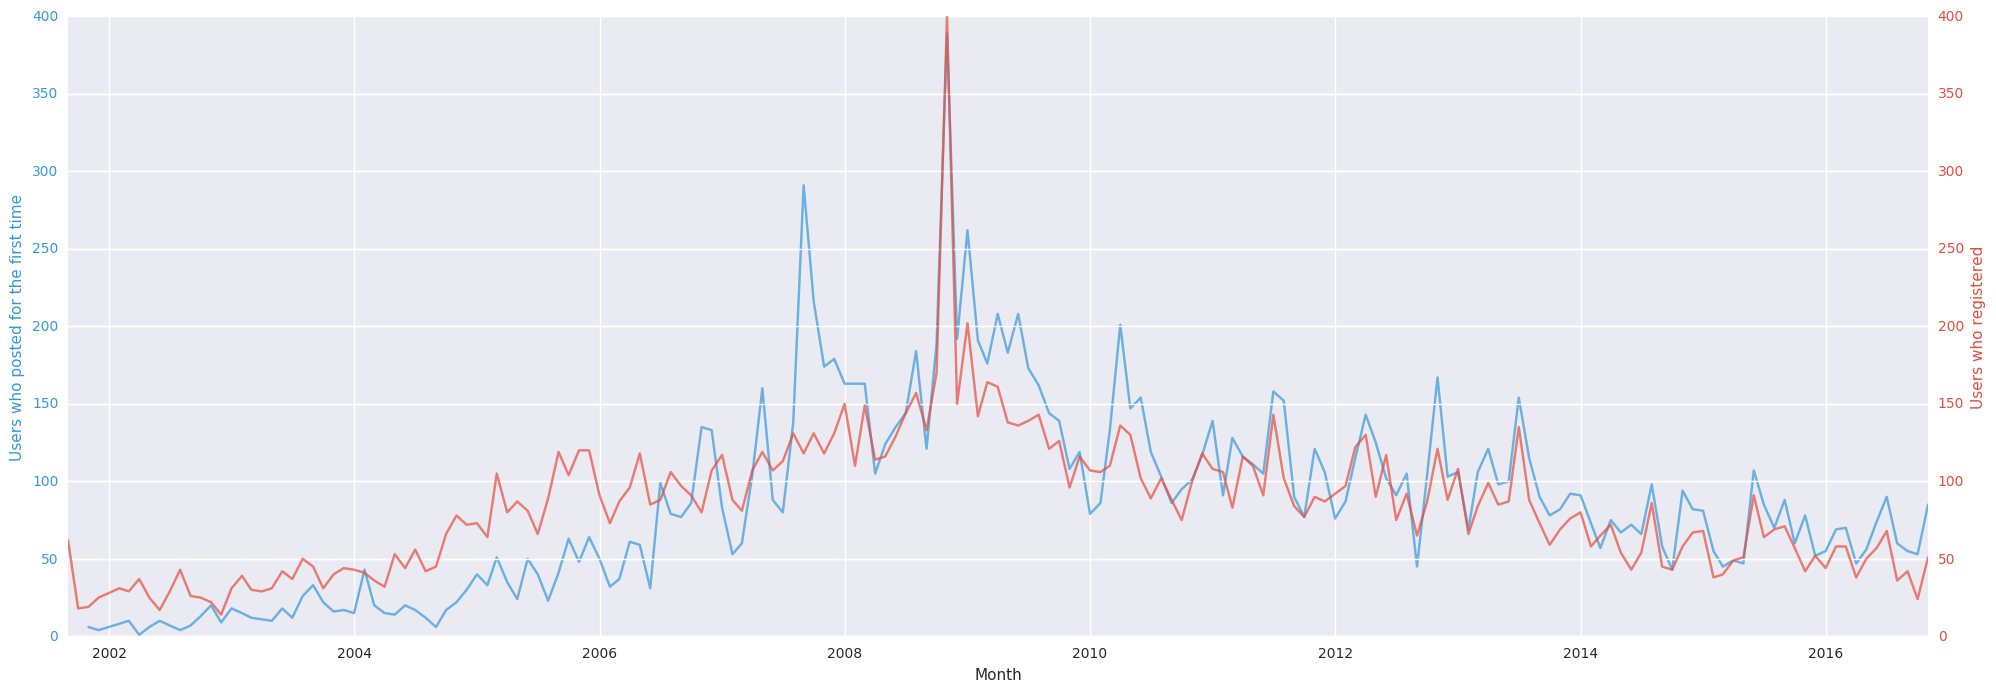

In [786]:
plot_two(first_post_month[2:-1], registered_users_by_month[2:-1], 'Month', 'Users who posted for the first time', 'Users who registered')

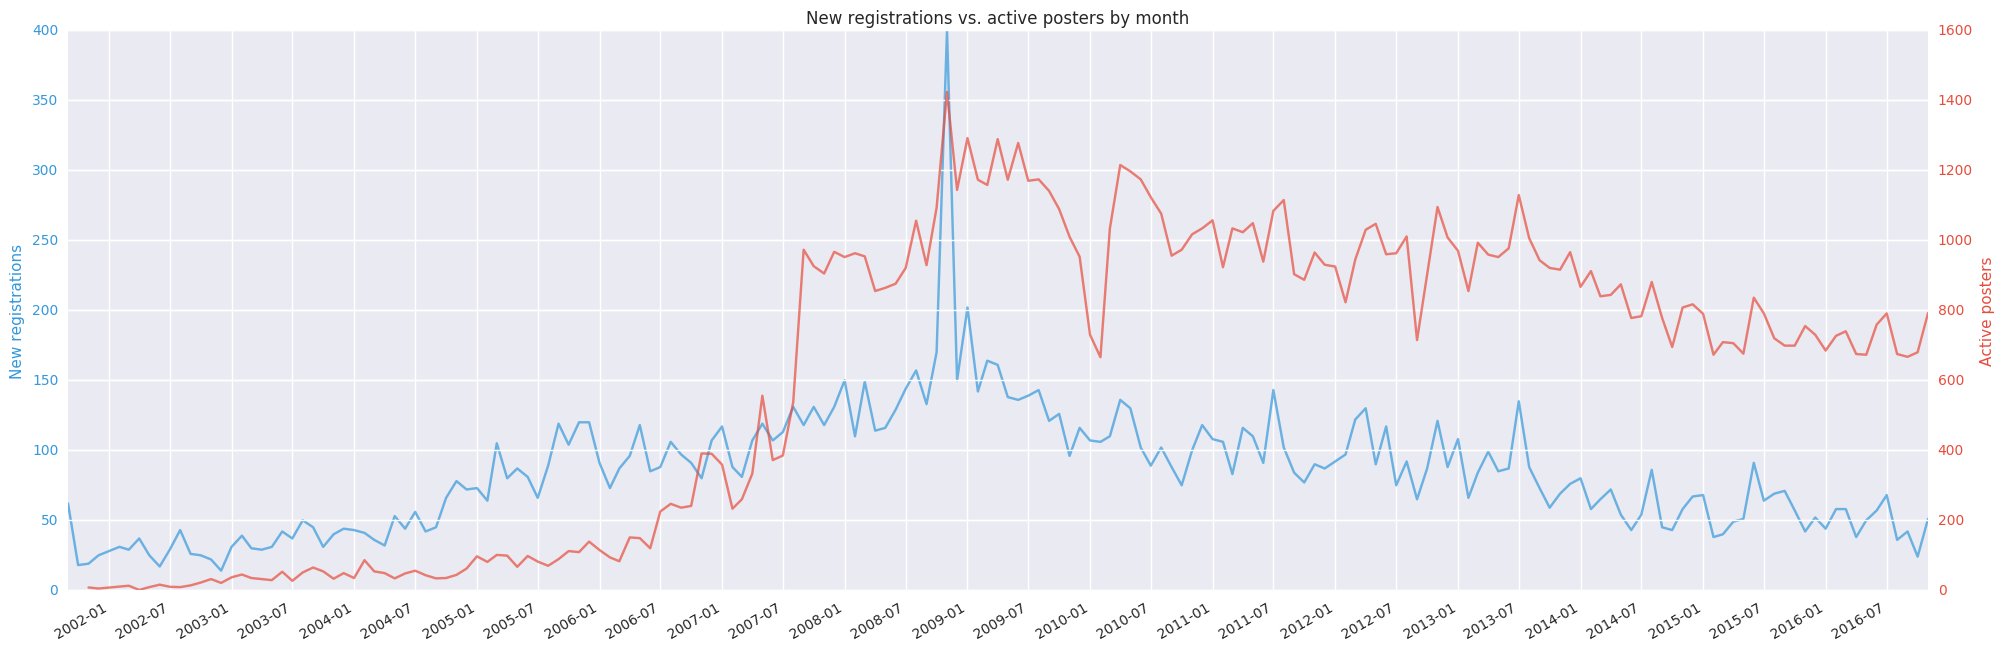

In [814]:
plot_two(registered_users_by_month[2:-1], authors_posting_per_month[2:-1], '', 'New registrations', 'Active posters', 'New registrations vs. active posters by month')

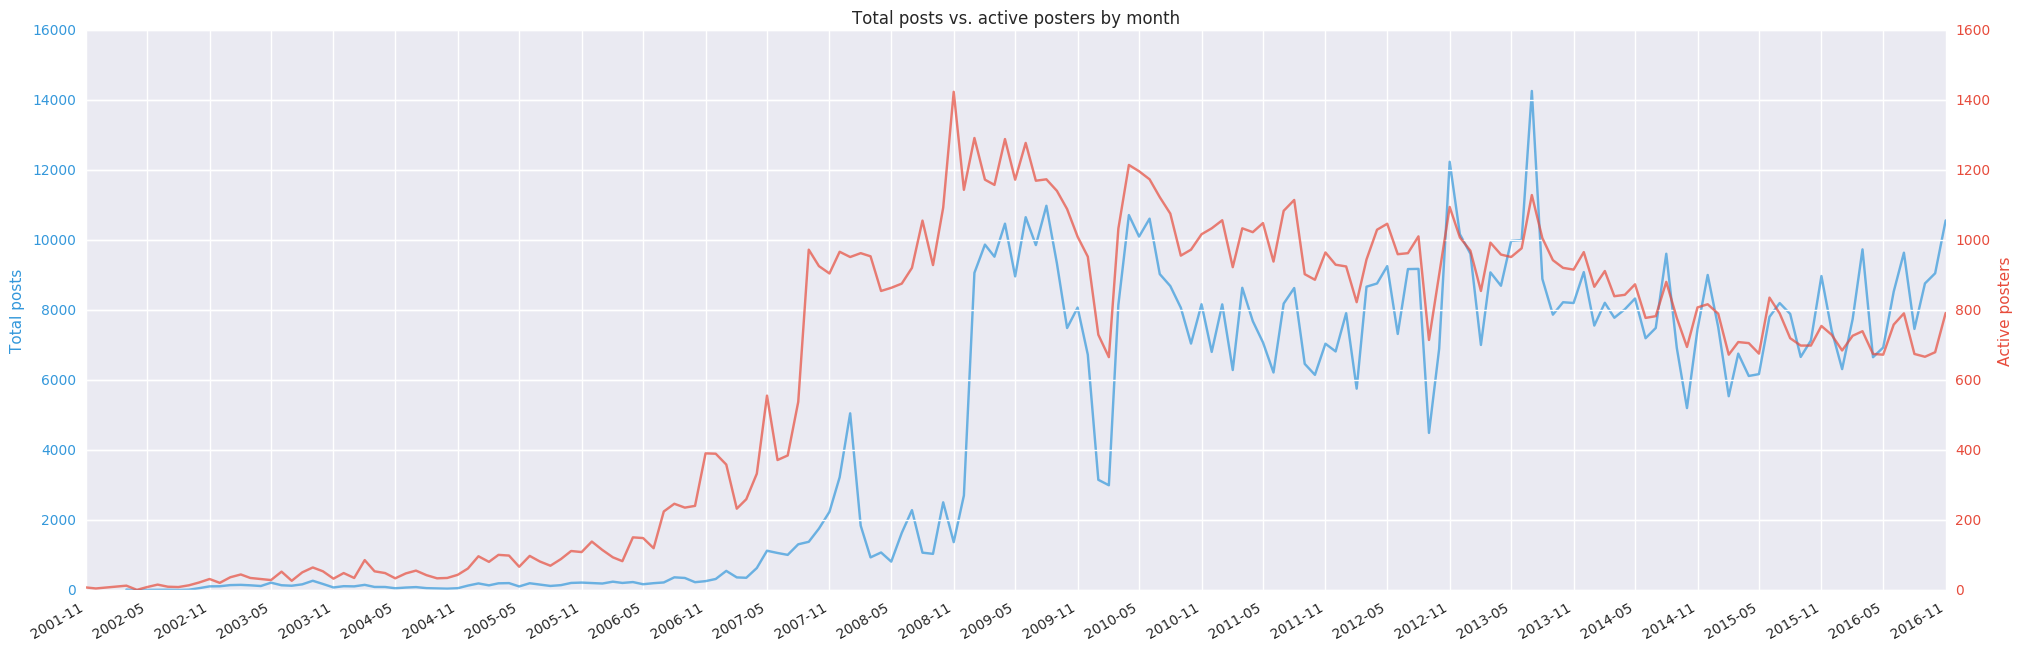

In [815]:
plot_two(counts_by_date_multi[2:-1], authors_posting_per_month[2:-1], '', 'Total posts', 'Active posters', 'Total posts vs. active posters by month')

# Text preprocessing

Now that the text is in a usable format, we need to...
* Tokenize
* Stem

Then we can generate tf-idf vectors at the (1) subpost and (2) thread level and do topic modeling!

In [391]:
df_subposts.to_csv('/home/sam/data/stormfront/subposts.csv', index=False)

In [9]:
import textacy

In [411]:
subposts_corpus = textacy.corpus.Corpus('en', texts=list(df_subposts.content))

In [414]:
terms_list = (doc.to_terms_list(ngrams=1, named_entities=True, as_strings=True) for doc in subposts_corpus)

In [419]:
doc_term_matrix, id2term = textacy.vsm.doc_term_matrix(
        terms_list, weighting='tfidf', normalize=True, smooth_idf=True,
        min_df=3, max_df=0.95, max_n_terms=200000)

In [ ]:
model = textacy.tm.TopicModel('lda', n_topics=20)

model.fit(doc_term_matrix)

In [423]:
doc_topic_matrix = model.transform(doc_term_matrix)

In [426]:
for topic_idx, top_terms in model.top_topic_terms(id2term):
    print('topic', topic_idx, ':', ' '.join(top_terms))

topic 0 : luck asia awesome wtc boycott ammo curious mtv --hlm silver
topic 1 : africans ha biden coward taste chavez hunter virus joe jooz
topic 2 : germany german france mestizo ireland ya french afghanistan eu source
topic 3 : beerchug.gif biggrin.gif good confused.gif hey bump great negroid rat pack
topic 4 : rofl.gif england tongue.gif huckabee wtf scary lebanon bang steele head.gif
topic 5 : pray tank tube tnb. blah unemployment swiss theft waco diebold
topic 6 : smile.gif link yep article jones alex post say interesting beck
topic 7 : not white ' like people think jews black 's know
topic 8 : adl palestinians sweden norway swedish moscow baldwin -jim bin bs.
topic 9 : wow sheeple sheep code flu omg freemason 0 myspace mcamnesty
topic 10 : christian scum remind fun yes negros egypt wwii groid dress
topic 11 : duke israel israeli mossad david iranian david duke click palestinian syria
topic 12 : eek.gif true ah smell jackson sharpton jesse hmm sa warrior
topic 13 : = cool.gif arya

# Thread-based LDA

The subpost-based topic modeling didn't yield very interesting topics. Let's try again with texts aggregated up to the thread level.

In [57]:
subposts_and_posts = pd.merge(df_subposts, df_posts, how='left', on='post_id', copy=False)
subposts_posts_and_titles = pd.merge(subposts_and_posts, df_titles, how='left', on='thread_url', copy=False)

subposts_posts_and_titles.head()

,post_id,parent_id,parent_content,content_x,video_links,author,author_join_date,author_location,author_posts,author_title,content_y,post_in_thread,thread_url,post_date,title
0,4230580,NaN,NaN,\nhttp://www.reuters.com/article/oddly...2&pag...,[],salvete amici,2005-10-04,"Christian, Free-market Libertarian",3602.0,Forum Member,"<div id=""post_message_4230580"">&#13;\n\t\t\t&#...",1,https://www.stormfront.org/forum/t390760,2007-05-24 15:19:00,Cat-Sized African Rats Plague Florida
1,4230591,4230580.0,NaN,I suppose they wouldn't go down well with a d...,[],Royal Blue,2005-10-04,NaN,1813.0,Forum Member,"<div id=""post_message_4230591"">&#13;\n\t\t\t&#...",2,https://www.stormfront.org/forum/t390760,2007-05-24 15:27:00,Cat-Sized African Rats Plague Florida
2,4230635,4230580.0,NaN,The blacks or the rats? confused.gif \n,[],ArcticThunder,2006-05-04,U.S.A.,3940.0,Account Inactive,"<div id=""post_message_4230635"">&#13;\n\t\t\t&#...",3,https://www.stormfront.org/forum/t390760,2007-05-24 15:52:00,Cat-Sized African Rats Plague Florida
3,4230666,4230580.0,NaN,OMG I'll have nightmares for weeks now...YUCK...,[],BeautynBrains1488,2007-05-04,Texico Amexica Where Wetbacks Rule,654.0,Forum Member,"<div id=""post_message_4230666"">&#13;\n\t\t\t&#...",4,https://www.stormfront.org/forum/t390760,2007-05-24 16:13:00,Cat-Sized African Rats Plague Florida
4,4230668,NaN,NaN,\r\n\t\t\t\r\n\t\t\tAre you talking about actu...,[],LOKI-Nevada,2002-03-04,Fled to Utah,7697.0,Account Disabled by Request,"<div id=""post_message_4230668"">&#13;\n\t\t\t&#...",5,https://www.stormfront.org/forum/t390760,2007-05-24 16:16:00,Cat-Sized African Rats Plague Florida


In [62]:
threads_groupby = subposts_posts_and_titles.groupby('thread_url')
titles = threads_groupby.title.first()
urls = threads_groupby.thread_url.first()
threads = threads_groupby.content_x.apply(lambda x: '\n'.join(x))

# Merge in author data here

In [23]:
df_titles.head()

,thread_url,title
0,https://www.stormfront.org/forum/t1000001,Black Female Attacked 83 Year Old Male at Groc...
1,https://www.stormfront.org/forum/t1000015,'It's making children cry': Police tell man to...
2,https://www.stormfront.org/forum/t1000028,MSNBCs Matthews: Tea Party Racist by Using Wo...
3,https://www.stormfront.org/forum/t1000034,Two Teachers Were Fired After Calling Students...
4,https://www.stormfront.org/forum/t1000039,Students suspended for wearing Confederate fla...


In [39]:
df_posts_and_titles = pd.merge(df_posts, df_titles, on='thread_url', copy=False)

df_posts_and_titles.head()

,author,author_join_date,author_location,author_posts,author_title,content,post_in_thread,thread_url,post_date,post_id,title
0,salvete amici,2005-10-04,"Christian, Free-market Libertarian",3602.0,Forum Member,"<div id=""post_message_4230580"">&#13;\n\t\t\t&#...",1,https://www.stormfront.org/forum/t390760,2007-05-24 15:19:00,4230580,Cat-Sized African Rats Plague Florida
1,Royal Blue,2005-10-04,NaN,1813.0,Forum Member,"<div id=""post_message_4230591"">&#13;\n\t\t\t&#...",2,https://www.stormfront.org/forum/t390760,2007-05-24 15:27:00,4230591,Cat-Sized African Rats Plague Florida
2,ArcticThunder,2006-05-04,U.S.A.,3940.0,Account Inactive,"<div id=""post_message_4230635"">&#13;\n\t\t\t&#...",3,https://www.stormfront.org/forum/t390760,2007-05-24 15:52:00,4230635,Cat-Sized African Rats Plague Florida
3,BeautynBrains1488,2007-05-04,Texico Amexica Where Wetbacks Rule,654.0,Forum Member,"<div id=""post_message_4230666"">&#13;\n\t\t\t&#...",4,https://www.stormfront.org/forum/t390760,2007-05-24 16:13:00,4230666,Cat-Sized African Rats Plague Florida
4,LOKI-Nevada,2002-03-04,Fled to Utah,7697.0,Account Disabled by Request,"<div id=""post_message_4230668"">&#13;\n\t\t\t&#...",5,https://www.stormfront.org/forum/t390760,2007-05-24 16:16:00,4230668,Cat-Sized African Rats Plague Florida


In [33]:
author_threads = df_posts.groupby(['thread_url', 'author']).apply(lambda row: 1)

author_threads

thread_url                                 author                 
https://www.stormfront.org/forum/t1000001  AZMD                       1
                                           BrooklynGal53              1
                                           Ex Muslim Alhamdulillah    1
                                           HungarianMadman            1
                                           MDK                        1
                                           Southern Cornbread         1
                                           WalterWaves                1
                                           mrjowee                    1
                                           registered2                1
https://www.stormfront.org/forum/t1000015  GrayGhost                  1
                                           LetsgoBlues                1
                                           MsScarlett                 1
                                           Ravening Wolf             

In [36]:
thread_authors = author_threads.reset_index().drop(0, axis=1)

from collections import defaultdict
threads_to_authors = defaultdict(set)

thread_authors.apply(lambda row: threads_to_authors[row.thread_url].add(row.author), axis=1)

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
16        None
17        None
18        None
19        None
20        None
21        None
22        None
23        None
24        None
25        None
26        None
27        None
28        None
29        None
          ... 
625917    None
625918    None
625919    None
625920    None
625921    None
625922    None
625923    None
625924    None
625925    None
625926    None
625927    None
625928    None
625929    None
625930    None
625931    None
625932    None
625933    None
625934    None
625935    None
625936    None
625937    None
625938    None
625939    None
625940    None
625941    None
625942    None
625943    None
625944    None
625945    None
625946    None
dtype: object

In [38]:
threads_to_authors['https://www.stormfront.org/forum/t999990']

{'Dandy Boneman',
 'FW190D6',
 'FedUpYT',
 'LostSadSpirit',
 'Pamela Rosa',
 'Rhiannon Shay',
 'SouthHip',
 'ThracianSword',
 'guest',
 'vagg'}

In [63]:
threads_corpus = textacy.corpus.Corpus('en', texts=list(threads), metadatas=({'url': x} for x in urls))

In [64]:
textacy.vsm.doc_term_matrix?

In [65]:
terms_list = (doc.to_terms_list(ngrams=1, named_entities=True, as_strings=True) for doc in threads_corpus)
doc_term_matrix, id2term = textacy.vsm.doc_term_matrix(
        terms_list, weighting='tfidf', normalize=True, smooth_idf=True,
        min_df=2, max_df=0.95, max_n_terms=200000)

In [457]:
model = textacy.tm.TopicModel('lda', n_topics=20)

model.fit(doc_term_matrix)

In [458]:
doc_topic_matrix = model.transform(doc_term_matrix)

In [460]:
for topic_idx, top_terms in model.top_topic_terms(id2term):
    print('topic', topic_idx, ':', ', '.join(top_terms))

topic 0 : israel, jews, iran, russia, germany, jewish, german, europe, holocaust, russian
topic 1 : james bond, npi, vip, vereen, rufus, daniel craig, espanol, shrek, wingsuit, roundtree
topic 2 : canton, erikson, graders, tbo.com, leif erikson day, leif erikson, 566, october 9 , 2015, tdd, february 22 , 2008
topic 3 : gucci, snatcher, gadson, jean raspail, arsenio, lee county, arsenio hall, fen, value, distinguishable
topic 4 : redskins, fidel, washer, fidel castro, redskin, braves, hocus, pocus, poofters, gourd
topic 5 : patel, jayant, cbo, bundaberg, jayant patel, soho, wheelbarrow, beattie, 3.69, shark
topic 6 : barron, antoine, maggie, grocer, horne, finch, 3800, bib, thurmond, belmont
topic 7 : latarian, anime, swimsuit, latarian milton, lamilton, chocolate city, taeshawn, wwl, ewwwww, lamilton taeshawn - youtube
topic 8 : arnie, auburn, pac, san fran, midlands, anne frank 's, cgi, race/religion, whoopee, west midlands
topic 9 : hhs, weston, valentine, bilderberger, englewood, 

In [485]:
for topic_idx, top_docs in model.top_topic_docs(doc_topic_matrix, topics=range(20), top_n=3):
    print('')    
    print(topic_idx)
    for j in top_docs:
        print(threads_corpus[j].metadata['title'])


0
Scientific conference held in Kazan states - bulgarians are from iranic origin
Ahmet Davutoglu says in Kiev Turkey will never recognize annexation of Crimea
The Enemy of Ukraine and White Europeans Have Been Defeated in Ukraine. East & West Ukraine Division Agreed Upon.

1
Man arrested for having sex with horses for third time, breaking leg in process
Black man arrested for raping pit bulls
Coming to the US? 35% of rural Brazilians admit to sex with animals.

2
Happy Leif Erikson Day 2014!
Happy Leif Erikson Day! (October 9th)
White House proclaims Leif Erikson Day 2015!

3
Gangsta Rapper gets tattoo of ice cream cone on his face
Confederate and NSDAP flags displayed in window of a home in diverse neighborhood
Arsenio Hall Show Takes A Huge DUMP!

4
Oldest person in the USA, oldest Jew in the world
Fidel Castro Excoriates Holocaust Deniers; Says Jew Have Been The Most Persecuted People In History
Protest over Redskins name in Denver Sunday as team faces the Broncos

5
UK:Negress Nur

In [66]:
model_nmf = textacy.tm.TopicModel('nmf', n_topics=20)

model_nmf.fit(doc_term_matrix)
doc_topic_matrix_nmf = model_nmf.transform(doc_term_matrix)

In [67]:
model_nmf_200 = textacy.tm.TopicModel('nmf', n_topics=200)

model_nmf_200.fit(doc_term_matrix)
doc_topic_matrix_nmf_200 = model_nmf_200.transform(doc_term_matrix)

In [74]:
doc_topic_matrix_20 = model_nmf.get_doc_topic_matrix(doc_term_matrix)

In [75]:
doc_topic_matrix_200 = model_nmf_200.get_doc_topic_matrix(doc_term_matrix)

In [76]:
doc_topic_matrix_20.shape, doc_topic_matrix_200.shape

((66147, 20), (66147, 200))

In [78]:
len(threads), len(threads_to_authors)

(66147, 66147)

In [201]:
df_topic_matrix_20 = pd.DataFrame(doc_topic_matrix_20, columns=map(str, range(20)))
df_topic_matrix_200 = pd.DataFrame(doc_topic_matrix_200, columns=map(str, range(200)))

Each document $d$ has a probability $p_t$ of belonging to a topic $t \in \{0, 1, ..., n\}$.

For each document, there is a subset of all the users $U \subset \{u_1, u_2, ...\}$ who have posted on the document.

To what extent do two topics $t_i$ and $t_j$ overlap in users?

---

Multiplying the matrix of documents and topics $DxT$ with the matrix of authors to documents $AxD$, we arrive at the matrix of authors to topics $AxT$. Each entry $(a, t)$ is the sum of the topic weights $d_{ai}, i=t$, so we divide each entry in each row by $\sum_{i=0}^{n} d_{ai}$

In [248]:
authors_to_weights_20 = defaultdict(list)
authors_to_weights_20_normalized = {}

for i, row in df_topic_matrix_20.iterrows():
    authors = threads_to_authors[urls[i]]
    for author in authors:
        authors_to_weights_20[author].append(row)
    
    if i % 1000 == 0:
        print('.', end='')
        
print('---')
        
for i, (author, weights) in enumerate(authors_to_weights_20.items()):
    authors_to_weights_20[author] = pd.DataFrame(weights).sum()
    
    if i % 1000 == 0:
        print('.', end='')
        
for i, (author, weights) in enumerate(authors_to_weights_20.items()):
    authors_to_weights_20[author] = authors_to_weights_20[author] / authors_to_weights_20[author].sum()

...................................................................---
................

In [228]:
authors_to_weights = defaultdict(list)

for i, row in df_topic_matrix_200.iterrows():
    authors = threads_to_authors[urls[i]]
    for author in authors:
        authors_to_weights[author].append(row)
    
    if i % 1000 == 0:
        print('.', end='')
        
print('---')
        
for i, (author, weights) in enumerate(authors_to_weights.items()):
    authors_to_weights[author] = pd.DataFrame(weights).sum()
    
    if i % 1000 == 0:
        print('.', end='')
        
for i, (author, weights) in enumerate(authors_to_weights.items()):
    authors_to_weights[author] = authors_to_weights[author] / authors_to_weights[author].sum()

...................................................................---
................

In [223]:
df_author_topic_matrix_20 = pd.DataFrame(authors_to_weights_20)
authors_with_more_than_median_posts = df_authors[(df_authors.author_posts > 92)].author
truncated_author_topic_matrix = df_author_topic_matrix_20[authors_with_more_than_median_posts]
df_author_topic_corrmatrix_20 = np.corrcoef(truncated_author_topic_matrix)

In [229]:
df_author_topic_matrix = pd.DataFrame(authors_to_weights)
authors_with_more_than_median_posts = df_authors[(df_authors.author_posts > 92)].author
truncated_author_topic_matrix = df_author_topic_matrix[authors_with_more_than_median_posts]
df_author_topic_corrmatrix = np.corrcoef(truncated_author_topic_matrix)

/home/sam/text-analytics/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/sam/text-analytics/venv/lib/python3.5/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


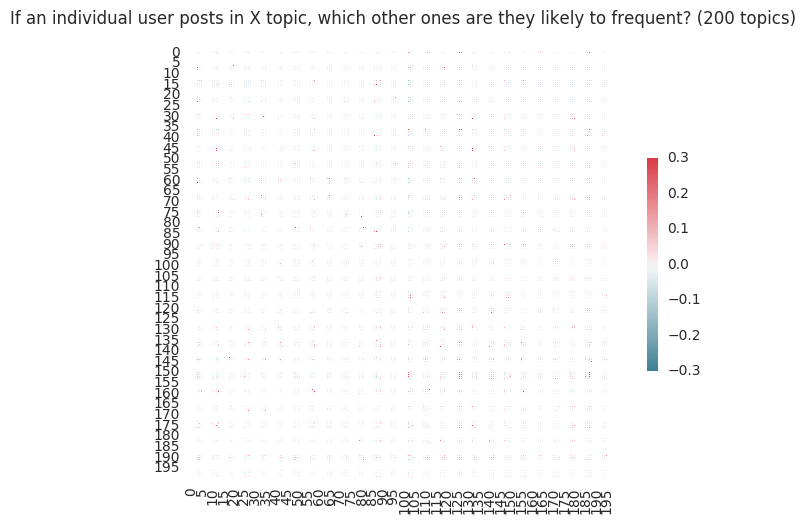

In [232]:
mask = np.diag(np.diag(df_author_topic_corrmatrix))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.plt.title('If an individual user posts in X topic, which other ones are they likely to frequent? (200 topics)\n')
sns.heatmap(df_author_topic_corrmatrix, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           xticklabels=1, yticklabels=1)

In [195]:
topic_names = [
    'Violence/meta',
    'Israel/Middle East',
    'Trump/Republicans',
    'Jews',
    'Russia/Eastern Europe',
    "American gov't",
    'Obama',
    'Muslims, Europe',
    'Mexico/US Border',
    'Germany/Hitler',
    'China, Asia',
    'Women, gender, rape',
    'Ron Paul',
    'Iran, nuclear war',
    'Police violence',
    'White/Black',
    'Hillary Clinton',
    'Schools',
    'France',
    'Sweden'
]

len(label_names)

19

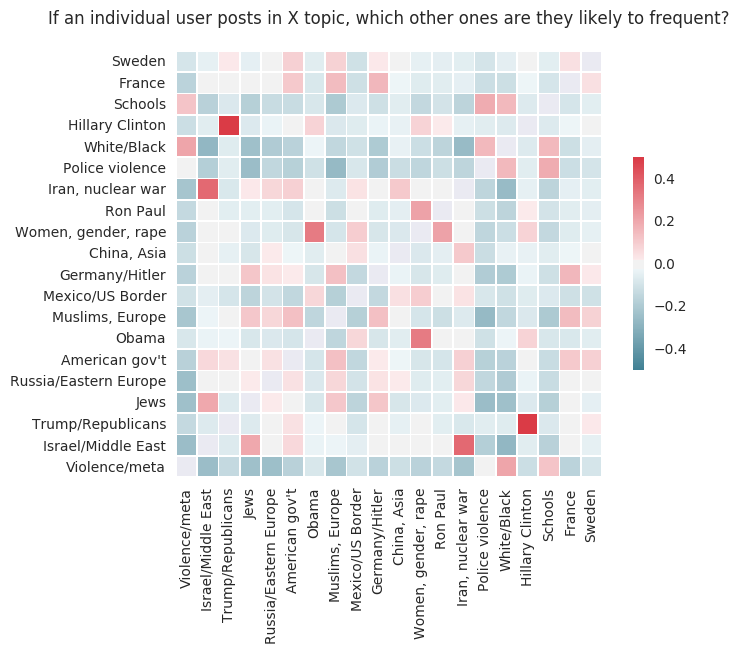

In [233]:
mask = np.diag(np.diag(df_author_topic_corrmatrix_20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.plt.title('If an individual user posts in X topic, which other ones are they likely to frequent?\n')
ax = sns.heatmap(df_author_topic_corrmatrix_20, mask=mask, cmap=cmap, vmax=.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           xticklabels=topic_names, yticklabels=topic_names)

ax.invert_yaxis()

In [ ]:
mask = np.diag(np.diag(df_author_topic_corrmatrix_20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.plt.title('If an individual user posts in X topic, which other ones are they likely to frequent?\n')
ax = sns.heatmap(df_author_topic_corrmatrix_20, mask=mask, cmap=cmap, vmax=.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           xticklabels=topic_names, yticklabels=topic_names)

ax.invert_yaxis()

In [106]:
corrmatrix = np.corrcoef(doc_topic_matrix_20.T)

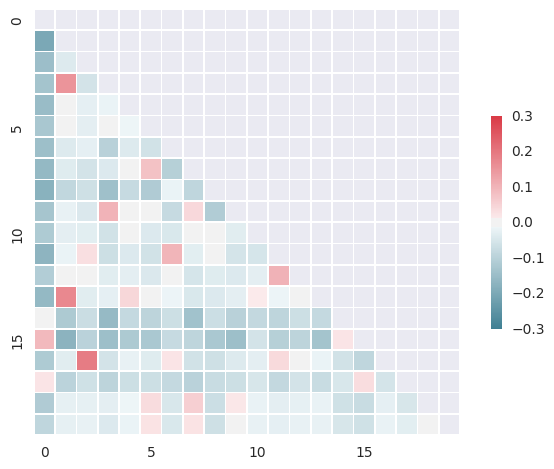

In [117]:
mask = np.zeros_like(corrmatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrmatrix, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5})

In [86]:
top_terms = [top_terms for _, top_terms in model_nmf_200.top_topic_terms(id2term, top_n=20)]

for topic_idx, top_docs in model_nmf_200.top_topic_docs(doc_topic_matrix_nmf_200, topics=range(200), top_n=10):
    print('')
    print(topic_idx)
    print('Top terms: ', ', '.join(top_terms[topic_idx]))
    print('--')
    for j in top_docs:
        print(df_titles[df_titles.thread_url == threads_corpus[j].metadata['url']]['title'])



0
Top terms:  attack, victim, beat, mob, assault, attacker, bus, terrorist, medium, carry, fight, punch, paris, violence, savage, defend, happen, teen, group, incident
--
777    Traveshia Blanks Charged In Two Random 'Knocko...
Name: title, dtype: object
16280    Teenager survives third terrorist attack
Name: title, dtype: object
2352    Mob of Blacks Videotape Their Attack on Disabl...
Name: title, dtype: object
2011    Black racist knockout game defendant acquitted...
Name: title, dtype: object
64205    Milwaukee man beaten by black mob declaring 'T...
Name: title, dtype: object
3495    Hate Crime Black Mob Beat Up White Man in Raci...
Name: title, dtype: object
47456    Negro attacks disabled man on bus
Name: title, dtype: object
52151    Another white kid attacked by negro in Portland.
Name: title, dtype: object
63151    Group of teens attack Rabbi in Germany
Name: title, dtype: object
51632    David Duke - I am doing a vid on Black violenc...
Name: title, dtype: object

1
Top ter

In [829]:
top_terms = [top_terms for _, top_terms in model_nmf.top_topic_terms(id2term, top_n=20)]

for topic_idx, top_docs in model_nmf.top_topic_docs(doc_topic_matrix_nmf, topics=range(20), top_n=10):
    print('')
    print(topic_idx)
    print('Top terms: ', ', '.join(top_terms[topic_idx]))
    print('--')
    for j in top_docs:
        print(threads_corpus[j].metadata['title'])



0
Top terms:  not, ', like, people, rofl.gif, think, know, good, look, be, 's, get, thing, time, video, go, day, beerchug.gif, say, rolleyes.gif
--
White man brutally beaten in pizza store by black thug as white crowd just watches
Here We Go~White kills black Over Loud Music!
Disgusting San Fran homo agenda revealed
*Video* Let's Meet Judge William Adams & What He Did To His Daughter!
Statement from self-immolation victim
Blacks gang up on white protester in Columbia, SC
Underage girl gang raped in Ohio. 13 min video went viral.
African gets into it with two whites guys , white guys keep it fair fight
Important News: Shooter in PA has ties to this Board...
Read! Who wants to be Moderated?

1
Top terms:  israel, israeli, palestinians, israelis, gaza, palestinian, zionist, jews, u.s., palestine, netanyahu, american, syria, hamas, us, jew, arab, egypt, aipac, jerusalem
--
Obama (A Employee Of International Jewry): "Israel Has A Right To Defend Itself"
"We will become like Israel" says Ge